In [1]:
import glob
import numpy as np
import tensorflow as tf
import cv2
import json
from sklearn.model_selection import train_test_split

In [2]:
train_dir = 'Training'
train_json = glob.glob(train_dir + '/*.json')

In [3]:
len(train_json)

72342

Val 1 미세각질
Val 2 피지과다
Val 3 모낭사이홍반
Val 4 모낭홍반/농포
Val 5 비듬
Val 6 탈모

각각 4가지 상태가 있는데, 이를 모두 고려한다면 4096 가지의 classification을 진행해야함. 따라서 각 상태에 대해서 증상 유, 무만 고려할 예정.

In [4]:
status = ['value_1', 'value_2', 'value_3', 'value_4', 'value_5', 'value_6']
with open(train_json[0]) as j:
    example = json.load(j)
    
example

{'image_id': '0013_A2LEBJJDE00060O_1602578303771_2',
 'image_file_name': '0013_A2LEBJJDE00060O_1602578303771_2_TH.jpg',
 'value_1': '0',
 'value_2': '1',
 'value_3': '2',
 'value_4': '0',
 'value_5': '1',
 'value_6': '0'}

In [5]:
# x_train_1, y_train_1 = [], []
# x_train_2, y_train_2 = [], []
# x_train_3, y_train_3 = [], []
# x_train_4, y_train_4 = [], []
# x_train_5, y_train_5 = [], []
# x_train_6, y_train_6 = [], []
# for name in train_json[10:]:
#     with open(name, 'r',encoding='utf-8') as j:
#         data = json.load(j)
#         f_name = data['image_file_name']
#         # print(train_dir+ '/' + f_name)
#         img = cv2.imread(train_dir+ '/' + f_name, cv2.IMREAD_COLOR)
#         # print(img)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = img[80:560,:]
#         img = cv2.resize(img, (64,64))
#         cv2.imwrite('Training/'+f_name,img)
        
        

In [6]:
saved_model = 'test.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [7]:
model1 = tf.keras.models.Sequential()
#
model1.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu',input_shape=(64,64,3)))  # conv2d 수행하면 64채널의 결과가 나오고, kernelsize = 3
model1.add(tf.keras.layers.Dropout(rate=0.5))                          #  DO1
model1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#
model1.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model1.add(tf.keras.layers.Dropout(rate=0.5))                          # DO2
model1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#
model1.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model1.add(tf.keras.layers.Dropout(rate=0.5))                           # DO3
model1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(4, activation='softmax'))
#
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       2

In [8]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
               
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [9]:
for i in range(18):
    x, y = [],[[],[],[],[],[],[],[]]
    for name in train_json[4019*i:4019*i+4019]:
        with open(name, 'r',encoding='utf-8') as j:
            data = json.load(j)
            f_name = data['image_file_name']
            img = cv2.imread(train_dir+ '/' + f_name, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            for idx, n in enumerate(status):
                i = idx + 1
    
                if data[n] == '0':
                    y[i].append(0)
                else:
                    y[i].append(int(data[n]))
            x.append(img)
            

    dump, y_1, y_2, y_3,y_4,y_5,y_6 = y
    x = np.array(x)
    x = x/255

    y_1 = np.array(y_1).reshape(-1,1)
    y_2 = np.array(y_2).reshape(-1,1)
    y_3 = np.array(y_3).reshape(-1,1)
    y_4 = np.array(y_4).reshape(-1,1)
    y_5 = np.array(y_5).reshape(-1,1)
    y_6 = np.array(y_6).reshape(-1,1)

    x_train, x_test = train_test_split(x, test_size=0.2,random_state=123)
    y_train_1, y_test_1 = train_test_split(y_1, test_size=0.2,random_state=123)

    history = model1.fit(x_train, y_train_1,
            epochs = 50,
            callbacks=[es, mc],
            batch_size = 16,
            validation_data = (x_test, y_test_1))

Epoch 1/50
201/201 [==============================] - 9s 13ms/step - loss: 0.6337 - accuracy: 0.8510 - val_loss: 1.0721 - val_accuracy: 0.8595

Epoch 00001: val_accuracy improved from -inf to 0.85945, saving model to test.h5
Epoch 2/50
201/201 [==============================] - 2s 10ms/step - loss: 0.5871 - accuracy: 0.8523 - val_loss: 1.0432 - val_accuracy: 0.8595

Epoch 00002: val_accuracy did not improve from 0.85945
Epoch 3/50
201/201 [==============================] - 2s 10ms/step - loss: 0.5893 - accuracy: 0.8523 - val_loss: 0.9876 - val_accuracy: 0.8595

Epoch 00003: val_accuracy did not improve from 0.85945
Epoch 4/50
201/201 [==============================] - 2s 10ms/step - loss: 0.5924 - accuracy: 0.8523 - val_loss: 0.9514 - val_accuracy: 0.8595

Epoch 00004: val_accuracy did not improve from 0.85945
Epoch 5/50
201/201 [==============================] - 2s 11ms/step - loss: 0.5797 - accuracy: 0.8523 - val_loss: 0.8683 - val_accuracy: 0.8595

Epoch 00005: val_accuracy did not 

In [10]:
import matplotlib.pyplot as plt

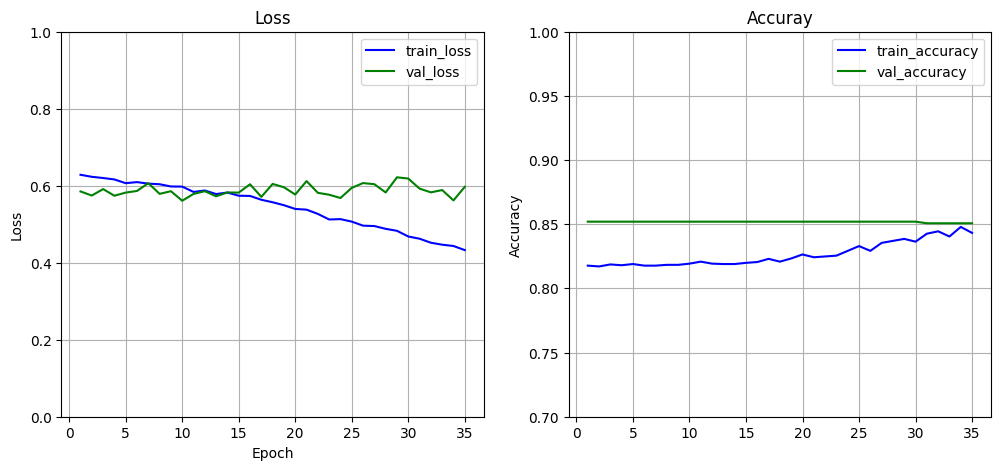

In [11]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1.0])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0.7,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# model = tf.keras.load_model('cp/test.ckpt')

In [ ]:
# x_train, y_train = [],[[],[],[],[],[],[],[]]
# for name in train_json[10000:20000]:
#     with open(name, 'r',encoding='utf-8') as j:
#         data = json.load(j)
#         f_name = data['image_file_name']
#         img = cv2.imread(train_dir+ '/' + f_name, cv2.IMREAD_COLOR)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         for idx, n in enumerate(status):
#             i = idx + 1
 
#             if data[n] == '0':
#                 y_train[i].append(0)
#             else:
#                 y_train[i].append(int(data[n]))
#         x_train.append(img)
        

# dump, y_train_1, y_train_2, y_train_3,y_train_4,y_train_5,y_train_6 = y_train
# x_train = np.array(x_train)
# x_train = x_train/255

# y_train_1 = np.array(y_train_1).reshape(-1,1)
# y_train_2 = np.array(y_train_2).reshape(-1,1)
# y_train_3 = np.array(y_train_3).reshape(-1,1)
# y_train_4 = np.array(y_train_4).reshape(-1,1)
# y_train_5 = np.array(y_train_5).reshape(-1,1)
# y_train_6 = np.array(y_train_6).reshape(-1,1)

# x_train, x_test = train_test_split(x_train, test_size=0.2)
# y_train_1, y_test_1 = train_test_split(y_train_1, test_size=0.2)